### Calculate Anchor Boxes

In [1]:
import sys
sys.path.append('../../')

TODO: Install deppendencies (PyYAML, opencv-python)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from object_detection.config.config_reader import ConfigReader
from object_detection.dataset.udacity_object_dataset import UdacityObjectDataset

pd.options.mode.chained_assignment = None

In [3]:
config_path = '/Users/adam.zvada/Documents/Dev/object-detection/config/test.yml'
config = ConfigReader(config_path)
dataset = UdacityObjectDataset(config)

Loading udacity dataset...


100%|██████████| 13063/13063 [09:12<00:00, 23.66it/s]


False


In [4]:
df_cord_label = dataset.df_true[['x_min', 'y_min', 'x_max', 'y_max', 'label']]
df_cord_label

,x_min,y_min,x_max,y_max,label
0,950.0,574.0,1004.0,620.0,car
1,1748.0,482.0,1818.0,744.0,pedestrian
2,872.0,586.0,926.0,632.0,car
3,686.0,566.0,728.0,618.0,truck
4,716.0,578.0,764.0,622.0,car
5,826.0,580.0,880.0,626.0,car
6,1540.0,488.0,1680.0,608.0,car
7,1646.0,498.0,1848.0,594.0,car
8,662.0,562.0,710.0,616.0,truck
9,686.0,576.0,730.0,628.0,car


In [5]:
org_image_width = 1920.0
org_image_height = 1980.0

In [6]:
# Scale cords to YOLO image size

# calculate size ratios, img - (h, w, 3)
width_ratio = config.image_width()/org_image_width
height_ratio = config.image_height()/org_image_height

# resize cords
df_cord_label['x_min'] = width_ratio * df_cord_label['x_min']
df_cord_label['x_max'] = width_ratio * df_cord_label['x_max']
df_cord_label['y_min'] = height_ratio * df_cord_label['y_min']
df_cord_label['y_max'] = height_ratio * df_cord_label['y_max']

df_cord_label

,x_min,y_min,x_max,y_max,label
0,221.62500,129.8750,234.250000,140.375,car
1,407.75000,109.0625,424.000000,168.375,pedestrian
2,203.37500,132.6250,216.000000,143.000,car
3,160.00000,128.1250,169.875000,139.875,truck
4,167.00000,130.7500,178.250000,140.750,car
5,192.62500,131.2500,205.250000,141.625,car
6,359.25000,110.4375,392.000000,137.625,car
7,384.00000,112.6875,431.000000,134.375,car
8,154.37500,127.1875,165.625000,139.375,truck
9,160.00000,130.3750,170.250000,142.125,car


In [7]:
# convert to x, y, w, h
df_cord_label['x'] = (df_cord_label['x_min'] + df_cord_label['x_max'])/2
df_cord_label['y'] = (df_cord_label['y_min'] + df_cord_label['y_max'])/2
df_cord_label['w'] = df_cord_label['x_max'] - df_cord_label['x_min']
df_cord_label['h'] = df_cord_label['y_max'] - df_cord_label['y_min']

df_cord_label

,x_min,y_min,x_max,y_max,label,x,y,w,h
0,221.62500,129.8750,234.250000,140.375,car,228.000000,135.1250,12.625000,10.5000
1,407.75000,109.0625,424.000000,168.375,pedestrian,416.000000,138.7500,16.250000,59.3125
2,203.37500,132.6250,216.000000,143.000,car,209.750000,137.7500,12.625000,10.3750
3,160.00000,128.1250,169.875000,139.875,truck,165.000000,134.0000,9.875000,11.7500
4,167.00000,130.7500,178.250000,140.750,car,172.625000,135.7500,11.250000,10.0000
5,192.62500,131.2500,205.250000,141.625,car,199.000000,136.5000,12.625000,10.3750
6,359.25000,110.4375,392.000000,137.625,car,375.500000,124.0000,32.750000,27.1875
7,384.00000,112.6875,431.000000,134.375,car,407.500000,123.5000,47.000000,21.6875
8,154.37500,127.1875,165.625000,139.375,truck,160.000000,133.2500,11.250000,12.1875
9,160.00000,130.3750,170.250000,142.125,car,165.125000,136.2500,10.250000,11.7500


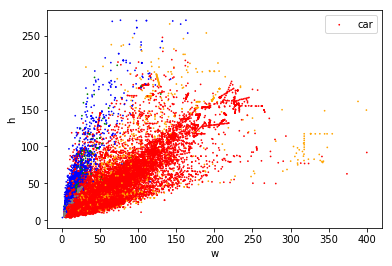

In [11]:
w = df_cord_label['w']
h = df_cord_label['h']
label = df_cord_label['label']
label_color = {'car': 'red', 'pedestrian': 'blue', 'truck': 'orange', 'trafficLight': 'grey', 'biker': 'green'}

ax = df_cord_label.plot.scatter(x='w', y='h', c=label.apply(lambda x: label_color[x]), s=0.51, legend=True)
ax.legend(label_color.keys())

# fig, ax = plt.subplots()
# for g in np.unique(group):
#     ix = np.where(group == g)
#     ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 100)
# ax.legend()
# plt.show()

In [13]:
def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_

In [14]:
def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])

In [15]:
def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)

In [16]:
def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

In [23]:
data = np.array(list(zip(w, h)))

for k in range(1,8):
    print(f'K-Means with {k} clusters')
    out = kmeans(data, k=k)
    print("Accuracy: {:.2f}%".format(avg_iou(data, out) * 100))
    print("Boxes:\n {}".format(out))

    ratios = np.around(out[:, 0] / out[:, 1], decimals=2).tolist()
    print("Ratios:\n {}".format(sorted(ratios)))

K-Means with 1 clusters
Accuracy: 36.91%
Boxes:
 [[10.75 21.25]]
Ratios:
 [0.51]
K-Means with 2 clusters
Accuracy: 52.46%
Boxes:
 [[12.5   14.5  ]
 [42.    32.125]]
Ratios:
 [0.86, 1.31]
K-Means with 3 clusters
Accuracy: 58.68%
Boxes:
 [[24.75   20.4375]
 [ 9.875  13.125 ]
 [62.0625 46.625 ]]
Ratios:
 [0.75, 1.21, 1.33]
K-Means with 4 clusters
Accuracy: 62.62%
Boxes:
 [[34.125  24.5   ]
 [ 7.9375 11.75  ]
 [15.875  16.75  ]
 [76.5    57.    ]]
Ratios:
 [0.68, 0.95, 1.34, 1.39]
K-Means with 5 clusters
Accuracy: 65.85%
Boxes:
 [[35.9375 26.3125]
 [ 7.875  10.875 ]
 [10.75   20.875 ]
 [19.625  14.875 ]
 [80.6875 59.75  ]]
Ratios:
 [0.51, 0.72, 1.32, 1.35, 1.37]
K-Means with 6 clusters
Accuracy: 68.48%
Boxes:
 [[ 11.1875   21.75   ]
 [105.9375   81.03125]
 [ 27.0625   19.5    ]
 [  7.5      11.3125 ]
 [ 47.125    34.4375 ]
 [ 16.375    12.6875 ]]
Ratios:
 [0.51, 0.66, 1.29, 1.31, 1.37, 1.39]
K-Means with 7 clusters
Accuracy: 70.30%
Boxes:
 [[126.5    103.25  ]
 [ 26.125   18.125 ]
 [ 64.75

In [26]:
image_width = config.image_width()
image_height = config.image_height()

anchores = [[24.75/image_width, 20.4375/image_height], [ 9.875/image_width, 13.125/image_height], [62.0625/image_width, 46.625/image_height]]
anchores

[[0.05524553571428571, 0.045619419642857144],
 [0.022042410714285716, 0.029296875],
 [0.13853236607142858, 0.10407366071428571]]